# GP_Kernel_Experiments for SatMobFusion

Essentially, we want to see how well conventional machine learning (ML) techniques work for this kind of data (mixed discrete and continuous masses). Specifically, we establish baselines using linear regression, RIDGE and LASSO regressions, logistic regression, and bootstrap aggregation (random forest). Then, we implement gaussian processes (GP) and compare performances.

Our goal is to make predictions about the current cluster given certain information

## Data Loading & Pre-Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from typing import Optional

import math
import numpy as np
import gpytorch
import torch
from torch import nn, Tensor
from torch.nn import functional as F

from gpytorch.constraints.constraints import Interval, Positive
from gpytorch.kernels.kernel import Kernel
from gpytorch.priors.prior import Prior

In [2]:
# Run this line every time in order to refresh the data
df = pd.read_csv('processed/user_0162bdca5925e11a37a48c507453734045b5d62cca0d6abc8300993dfbf8b69e.csv')

# Add additional corrections as needed
df['last_one'] = df['last_one'].fillna(-1)
df['last_two'] = df['last_two'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three'] = df['last_three'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_three_activity_duration'] = df['last_three_activity_duration'].apply(lambda x: np.fromstring(x[1 : len(x) - 1], dtype = float, sep = ','))
df['last_start_time'] = pd.to_datetime(df['last_start_time'])
df['leaving_datetime'] = pd.to_datetime(df['leaving_datetime'])

# Add additional features
df['leaving_hour'] = df['leaving_datetime'].dt.hour.astype(int)
df['day_of_week'] = df['leaving_datetime'].dt.dayofweek # Monday = 0, Sunday = 6
df['is_weekday'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)

# Note that lists are non-hashable, so we need to convert them to tuples
df['last_three'] = df['last_three'].apply(lambda x: tuple(x))
df['last_two'] = df['last_two'].apply(lambda x: tuple(x))

df['third_last_one'] = df['last_three'].apply(lambda x: x[2]).fillna(-1)
df['second_last_one'] = df['last_two'].apply(lambda x: x[1]).fillna(-1)

# View the data
pd.options.display.max_columns = None
df.head()

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,last_three_end_time,last_three_lat,last_three_lng,last_three_dist,last_dist,second_last_dist,third_last_dist,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,leaving_hour,day_of_week,is_weekday,third_last_one,second_last_one
0,2019-12-31 14:49:22,2019-12-31 15:58:02,0,58813.0,-1.0,"(nan, nan)","(nan, nan, nan)",69,"[nan, nan, nan]","(NaT, NaT, NaT)","(NaT, NaT, NaT)","(nan, nan, nan)","(nan, nan, nan)","(nan, nan, nan)",NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1,1,-1.0,-1.0
1,2019-12-31 17:01:04,2019-12-31 19:45:05,6,52032.0,0.0,"(0.0, nan)","(0.0, nan, nan)",164,"[69.0, nan, nan]","(Timestamp('2019-12-31 14:49:22'), NaT, NaT)","(Timestamp('2019-12-31 15:58:02'), NaT, NaT)","(47.22057343, nan, nan)","(-122.3467407, nan, nan)","(58813.0, nan, nan)",58813.0,NaN,NaN,2019-12-31 14:49:22,NaN,NaN,2019-12-31 15:58:02,NaN,NaN,69.0,NaN,NaN,19,1,1,-1.0,-1.0
2,2019-12-31 20:32:41,2020-01-01 01:35:33,3,38063.0,6.0,"(6.0, 0.0)","(6.0, 0.0, nan)",303,"[164.0, 69.0, nan]","(Timestamp('2019-12-31 17:01:04'), Timestamp('...","(Timestamp('2019-12-31 19:45:05'), Timestamp('...","(47.518939, 47.22057343, nan)","(-121.84213555, -122.3467407, nan)","(52032.0, 58813.0, nan)",52032.0,58813.0,NaN,2019-12-31 17:01:04,2019-12-31 14:49:22,NaN,2019-12-31 19:45:05,2019-12-31 15:58:02,NaN,164.0,69.0,NaN,1,2,1,-1.0,0.0
3,2020-01-01 02:41:51,2020-01-02 08:52:52,0,4705.0,3.0,"(3.0, 6.0)","(3.0, 6.0, 0.0)",1811,"[303.0, 164.0, 69.0]","(Timestamp('2019-12-31 20:32:41'), Timestamp('...","(Timestamp('2020-01-01 01:35:33'), Timestamp('...","(47.8473012, 47.518939, 47.22057343)","(-122.2763971, -121.84213555, -122.3467407)","(38063.0, 52032.0, 58813.0)",38063.0,52032.0,58813.0,2019-12-31 20:32:41,2019-12-31 17:01:04,2019-12-31 14:49:22,2020-01-01 01:35:33,2019-12-31 19:45:05,2019-12-31 15:58:02,303.0,164.0,69.0,8,3,1,0.0,6.0
4,2020-01-02 09:21:03,2020-01-02 14:45:51,1,4705.0,0.0,"(0.0, 3.0)","(0.0, 3.0, 6.0)",325,"[1811.0, 303.0, 164.0]","(Timestamp('2020-01-01 02:41:51'), Timestamp('...","(Timestamp('2020-01-02 08:52:52'), Timestamp('...","(47.22057343, 47.8473012, 47.518939)","(-122.3467407, -122.2763971, -121.84213555)","(4705.0, 38063.0, 52032.0)",4705.0,38063.0,52032.0,2020-01-01 02:41:51,2019-12-31 20:32:41,2019-12-31 17:01:04,2020-01-02 08:52:52,2020-01-01 01:35:33,2019-12-31 19:45:05,1811.0,303.0,164.0,14,3,1,6.0,3.0


## Encoding/Decoding

In [114]:
# Create a function that encodes the origin-destination combinations
def encode_combinations(row, col1, col2, combinations_dict):
    # Get the origin-destination combination
    combination = row[[col1, col2]].values.tolist()
    # Get the index of the combination
    index = list(combinations_dict.values()).index(combination)
    # Return the index
    return index

# Create a function that decodes the origin-destination combinations
def decode_combinations(row, combinations_dict):
    # Get the index
    index = row['combinations']
    # Get the origin-destination combination
    combination = combinations_dict[index]
    # Return the combination
    return combination

## Hamming Kernel Code

## Random Forest

In [115]:
import scipy.stats 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class RandomForest: 
    """
    A majority vote random forest classifier
    """
    
    def __init__(self, num_trees, max_depth=None):
        """
        Constructs a RandomForest that uses the given number of trees, each with a 
        max depth of max_depth.
        """
        self._trees = [
            DecisionTreeClassifier(max_depth=max_depth, random_state=1) 
            for i in range(num_trees)
        ]
        
    def fit(self, X):
        """
        Takes an input dataset X and trains each tree on a random subset of the data.
        Sampling is done with replacement.
        """

        for mini_tree in self._trees:
            mini_data = X.iloc[np.random.randint(0, X.shape[0], X.shape[0])]
            mini_tree.fit(mini_data['combinations'].to_numpy().reshape(-1, 1), mini_data['cluster'])
            
    def predict(self, X):
        """
        Takes an input dataset X and returns the predictions for each example in X.
        """
        # Builds up a 2d array with n rows and T columns
        # where n is the number of points to classify and T is the number of trees
        predictions = np.zeros((len(X), len(self._trees)))
        for i, tree in enumerate(self._trees):
            # Make predictions using the current tree
            preds = tree.predict(X)
            
            # Store those predictions in ith column of the 2d array
            predictions[:, i] = preds
            
        # For each row of predictions, find the most frequent label (axis=1 means across columns)
        return scipy.stats.mode(predictions, axis=1, keepdims=False)[0]

In [116]:
# Use variables to specify the columns to encode
item1 = 'last_one'
item2 = 'leaving_hour'

# Encode the data such that each combination of origin and destination is a unique number
# Create a list of unique last_two combinations
unique_combinations = df[[item1, item2]].drop_duplicates().reset_index(drop=True)

# Create a dictionary of unique origin-destination combinations
unique_combinations_dict = dict(zip(range(0, len(unique_combinations)), unique_combinations.values.tolist()))

# Encode the origins and destinations
df['combinations'] = df.apply(lambda x: encode_combinations(x, item1, item2, unique_combinations_dict), axis=1)

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set['combinations'].values, dtype=torch.float32)
x_test = torch.tensor(test_set['combinations'].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [117]:
# First calculate the accuracies for each depth
depths = list(range(1, 26, 2))
rf_accuracies = []
best_depth = 0
best_accuracy = 0

for i in depths:
    # Train and evaluate our RandomForest classifier with given max_depth 
    forest = RandomForest(15, max_depth=i)
    forest.fit(train_set)
    train_score = accuracy_score(forest.predict(train_set['combinations'].to_numpy().reshape(-1, 1)), train_set['cluster'])
    test_score = accuracy_score(forest.predict(test_set['combinations'].to_numpy().reshape(-1, 1)), test_set['cluster'])
    rf_accuracies.append((train_score, test_score))
    
    if test_score > best_accuracy:
        best_accuracy = test_score
        best_depth = i

print("Best Accuracy: ", best_accuracy, "\nBest Depth: ", best_depth, sep="")

Best Accuracy: 0.9139784946236559
Best Depth: 13


In [118]:
EMPTY_SIZE = torch.Size([])


class HammingIMQKernel(Kernel):
    r"""
    Computes a covariance matrix based on the inverse multiquadratic Hamming kernel
    between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:

    .. math::
       \begin{equation*}
            k_{\text{H-IMQ}}(\mathbf{x_1}, \mathbf{x_2}) =
            \left( \frac{1 + \alpha}{\alpha + d_{\text{Hamming}}(x1, x2)} \right)^\beta
       \end{equation*}
    where :math:`\alpha` and :math:`\beta` are strictly positive scale parameters.
    This kernel was proposed in `Biological Sequence Kernels with Guaranteed Flexibility`.
    See http://arxiv.org/abs/2304.03775 for more details.

    This kernel is meant to be used for fixed-length one-hot encoded discrete sequences.
    Because GPyTorch is particular about dimensions, the one-hot sequence encoding should be flattened
    to a vector with length :math:`T \times V`, where :math:`T` is the sequence length and :math:`V` is the
    vocabulary size.

    :param vocab_size: The size of the vocabulary.
    :param batch_shape: Set this if you want a separate kernel hyperparameters for each batch of input
        data. It should be :math:`B_1 \times \ldots \times B_k` if :math:`\mathbf{x_1}` is
        a :math:`B_1 \times \ldots \times B_k \times N \times D` tensor.
    :param alpha_prior: Set this if you want to apply a prior to the
        alpha parameter.
    :param: alpha_constraint: Set this if you want to apply a constraint
        to the alpha parameter. If None is passed, the default is `Positive()`.
    :param beta_prior: Set this if you want to apply a prior to the
        beta parameter.
    :param beta_constraint: Set this if you want to apply a constraint
        to the beta parameter. If None is passed, the default is `Positive()`.

    Example:
        >>> vocab_size = 8
        >>> x_cat = torch.tensor([[7, 7, 7, 7], [5, 7, 3, 4]])  # batch_size x seq_length
        >>> x_one_hot = F.one_hot(x_cat, num_classes=vocab_size)  # batch_size x seq_length x vocab_size
        >>> x_flat = x_one_hot.view(*x_cat.shape[:-1], -1)  # batch_size x (seq_length * vocab_size)
        >>> covar_module = gpytorch.kernels.HammingIMQKernel(vocab_size=vocab_size)
        >>> covar = covar_module(x_flat)  # Output: LinearOperator of size (2 x 2)
    """

    def __init__(
        self,
        vocab_size: int,
        batch_shape: torch.Size = EMPTY_SIZE,
        alpha_prior: Optional[Prior] = None,
        alpha_constraint: Optional[Interval] = None,
        beta_prior: Optional[Prior] = None,
        beta_constraint: Optional[Interval] = None,
    ):
        super().__init__(batch_shape=batch_shape)
        self.vocab_size = vocab_size
        # add alpha (scale) parameter
        alpha_constraint = Positive() if alpha_constraint is None else alpha_constraint
        self.register_parameter(
            name="raw_alpha",
            parameter=nn.Parameter(torch.zeros(*self.batch_shape, 1)),
        )
        if alpha_prior is not None:
            self.register_prior("alpha_prior", alpha_prior, self._alpha_param, self._alpha_closure)
        self.register_constraint("raw_alpha", alpha_constraint)

        # add beta parameter
        beta_constraint = Positive() if beta_constraint is None else beta_constraint
        self.register_parameter(
            name="raw_beta",
            parameter=nn.Parameter(torch.zeros(*self.batch_shape, 1)),
        )
        if beta_prior is not None:
            self.register_prior("beta_prior", beta_prior, self._beta_param, self._beta_closure)
        self.register_constraint("raw_beta", beta_constraint)

    @property
    def alpha(self) -> Tensor:
        return self.raw_alpha_constraint.transform(self.raw_alpha)

    @alpha.setter
    def alpha(self, value: Tensor):
        self._set_alpha(value)

    def _alpha_param(self, m: Kernel) -> Tensor:
        # Used by the alpha_prior
        return m.alpha

    def _alpha_closure(self, m: Kernel, v: Tensor) -> Tensor:
        # Used by the alpha_prior
        return m._set_alpha(v)

    def _set_alpha(self, value: Tensor):
        # Used by the alpha_prior
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_alpha)
        self.initialize(raw_alpha=self.raw_alpha_constraint.inverse_transform(value))

    @property
    def beta(self) -> Tensor:
        return self.raw_beta_constraint.transform(self.raw_beta)

    @beta.setter
    def beta(self, value: Tensor):
        self._set_beta(value)

    def _beta_param(self, m: Kernel) -> Tensor:
        # Used by the beta_prior
        return m.beta

    def _beta_closure(self, m: Kernel, v: Tensor) -> Tensor:
        # Used by the beta_prior
        return m._set_beta(v)

    def _set_beta(self, value: Tensor):
        # Used by the beta_prior
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_beta)
        self.initialize(raw_beta=self.raw_beta_constraint.inverse_transform(value))

    def _imq(self, dist: Tensor) -> Tensor:
        return ((1 + self.alpha) / (self.alpha + dist)).pow(self.beta)

    def forward(self, x1: Tensor, x2: Tensor, diag: bool = False, **params):
        # GPyTorch is pretty particular about dimensions so we need to unflatten the one-hot encoding
        x1 = x1.view(*x1.shape[:-1], -1, self.vocab_size)
        x2 = x2.view(*x2.shape[:-1], -1, self.vocab_size)

        x1_eq_x2 = torch.equal(x1, x2)

        if diag:
            if x1_eq_x2:
                res = ((1 + self.alpha) / self.alpha).pow(self.beta)
                skip_dims = [-1] * len(self.batch_shape)
                return res.expand(*skip_dims, x1.size(-3))
            else:
                dist = x1.size(-2) - (x1 * x2).sum(dim=(-1, -2))
                return self._imq(dist)

        else:
            dist = hamming_dist(x1, x2, x1_eq_x2)

        return self._imq(dist)


def hamming_dist(x1: Tensor, x2: Tensor, x1_eq_x2: bool) -> Tensor:
    res = x1.size(-2) - (x1.unsqueeze(-3) * x2.unsqueeze(-4)).sum(dim=(-1, -2))
    if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
        res.diagonal(dim1=-2, dim2=-1).fill_(0)
    # Zero out negative values
    #print(res.clamp_min_(0))
    return res.clamp_min_(0)

## GP Experiments

### Simple ExactGP + RBF 

In [119]:
# Use variables to specify the columns to encode
item1 = 'last_one'
item2 = 'leaving_hour'

# Encode the data such that each combination of origin and destination is a unique number
# Create a list of unique last_two combinations
unique_combinations = df[[item1, item2]].drop_duplicates().reset_index(drop=True)

# Create a dictionary of unique origin-destination combinations
unique_combinations_dict = dict(zip(range(0, len(unique_combinations)), unique_combinations.values.tolist()))

# Encode the origins and destinations
df['combinations'] = df.apply(lambda x: encode_combinations(x, item1, item2, unique_combinations_dict), axis=1)

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set['combinations'].values, dtype=torch.float32)
x_test = torch.tensor(test_set['combinations'].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [120]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [121]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 4.317
Iter 2/100 - Loss: 4.082
Iter 3/100 - Loss: 3.876
Iter 4/100 - Loss: 3.693
Iter 5/100 - Loss: 3.531
Iter 6/100 - Loss: 3.388
Iter 7/100 - Loss: 3.262
Iter 8/100 - Loss: 3.152
Iter 9/100 - Loss: 3.054
Iter 10/100 - Loss: 2.968
Iter 11/100 - Loss: 2.893
Iter 12/100 - Loss: 2.826
Iter 13/100 - Loss: 2.767
Iter 14/100 - Loss: 2.715
Iter 15/100 - Loss: 2.669
Iter 16/100 - Loss: 2.628
Iter 17/100 - Loss: 2.592
Iter 18/100 - Loss: 2.560
Iter 19/100 - Loss: 2.532
Iter 20/100 - Loss: 2.507
Iter 21/100 - Loss: 2.484
Iter 22/100 - Loss: 2.464
Iter 23/100 - Loss: 2.446
Iter 24/100 - Loss: 2.430
Iter 25/100 - Loss: 2.415
Iter 26/100 - Loss: 2.402
Iter 27/100 - Loss: 2.390
Iter 28/100 - Loss: 2.379
Iter 29/100 - Loss: 2.370
Iter 30/100 - Loss: 2.361
Iter 31/100 - Loss: 2.353
Iter 32/100 - Loss: 2.346
Iter 33/100 - Loss: 2.339
Iter 34/100 - Loss: 2.333
Iter 35/100 - Loss: 2.328
Iter 36/100 - Loss: 2.323
Iter 37/100 - Loss: 2.318
Iter 38/100 - Loss: 2.314
Iter 39/100 - Loss: 2

In [122]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_prediction = likelihood(model(x_test))

In [123]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -2,  0,  0, -3,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,
         0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -2,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0, -2,  0,  0,  0,  0, -1,  0,
         0,  0,  0,  0,  0, -2,  0, -2, -2,  0,  0, -2, -2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [124]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 83.87%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/3212484906.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


### Dirichlet Classification Experiments

#### Last Three Predict Current Location

In [125]:
dummies1 = pd.get_dummies(df['third_last_one']).values
dummies2 = pd.get_dummies(df['second_last_one']).values
dummies3 = pd.get_dummies(df['last_one']).values

# connect old data fram with new one horizontally
new_df = pd.concat([df, pd.DataFrame(dummies1), pd.DataFrame(dummies2), pd.DataFrame(dummies3)], axis=1)
train_set, test_set = train_test_split(new_df, test_size = 0.2, random_state=42)

# The number of unique locations
locations = dummies1.shape[1] + dummies2.shape[1] + dummies3.shape[1]

# x_train is last columns of train_set
x_train = torch.tensor(train_set.iloc[:, -(locations):].values, dtype=torch.int64)
print("training shape:", x_train.shape)

# x_test is last columns of test_set
x_test = torch.tensor(test_set.iloc[:, -(locations):].values, dtype=torch.int64)
print("testing shape:", x_test.shape)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.int64)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.int64)

training shape: torch.Size([369, 64])
testing shape: torch.Size([93, 64])


In [126]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(y_train, learn_additional_noise=True)
model = DirichletGPModel(x_train, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [127]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/100 - Loss: 55.581   lengthscale: 0.693   noise: 0.693
Iter 6/100 - Loss: 45.339   lengthscale: 0.973   noise: 0.609
Iter 11/100 - Loss: 41.190   lengthscale: 1.274   noise: 0.467
Iter 16/100 - Loss: 39.840   lengthscale: 1.531   noise: 0.356
Iter 21/100 - Loss: 39.283   lengthscale: 1.726   noise: 0.289
Iter 26/100 - Loss: 39.004   lengthscale: 1.866   noise: 0.256
Iter 31/100 - Loss: 38.841   lengthscale: 1.965   noise: 0.244
Iter 36/100 - Loss: 38.738   lengthscale: 2.036   noise: 0.244
Iter 41/100 - Loss: 38.667   lengthscale: 2.087   noise: 0.248
Iter 46/100 - Loss: 38.615   lengthscale: 2.125   noise: 0.252
Iter 51/100 - Loss: 38.576   lengthscale: 2.155   noise: 0.254
Iter 56/100 - Loss: 38.544   lengthscale: 2.180   noise: 0.254
Iter 61/100 - Loss: 38.517   lengthscale: 2.202   noise: 0.253
Iter 66/100 - Loss: 38.494   lengthscale: 2.222   noise: 0.253
Iter 71/100 - Loss: 38.474   lengthscale: 2.241   noise: 0.254
Iter 76/100 - Loss: 38.456   lengthscale: 2.259   noise: 

In [128]:
# evaluate our model
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(x_test)
    pred_means = test_dist.loc

In [129]:
observed_prediction = pred_means.max(0)[1]
torch.tensor(y_actual - observed_prediction, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/1401055272.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction, dtype=torch.int)


tensor([ 0,  0,  2,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0, 10,
         3,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  3,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  3,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [130]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 84.95%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/4178206740.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


### HBT Experiments

In [131]:
# Get all rows where cluster == 0 and the second value of last_two is 0
one_stop_hbt = df[(df['cluster'] == 0) & (df['last_two'].apply(lambda x: x[1]) == 0.0)]
one_stop_hbt.head()

,datetime,leaving_datetime,cluster,dist,last_one,last_two,last_three,activity_duration,last_three_activity_duration,last_three_start_time,last_three_end_time,last_three_lat,last_three_lng,last_three_dist,last_dist,second_last_dist,third_last_dist,last_start_time,second_last_start_time,third_last_start_time,last_end_time,second_last_end_time,third_last_end_time,last_activity_duration,second_last_activity_duration,third_last_activity_duration,leaving_hour,day_of_week,is_weekday,combinations,third_last_one,second_last_one
5,2020-01-02 14:59:11,2020-01-02 17:07:03,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 3.0)",128,"[325.0, 1811.0, 303.0]","(Timestamp('2020-01-02 09:21:03'), Timestamp('...","(Timestamp('2020-01-02 14:45:51'), Timestamp('...","(47.2980423, 47.22057343, 47.8473012)","(-122.3381958, -122.3467407, -122.2763971)","(4705.0, 4705.0, 38063.0)",4705.0,4705.0,38063.0,2020-01-02 09:21:03,2020-01-01 02:41:51,2019-12-31 20:32:41,2020-01-02 14:45:51,2020-01-02 08:52:52,2020-01-01 01:35:33,325.0,1811.0,303.0,17,3,1,5,3.0,0.0
18,2020-01-06 14:11:02,2020-01-06 16:02:52,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 3.0)",112,"[279.0, 1814.0, 693.0]","(Timestamp('2020-01-06 09:12:15'), Timestamp('...","(Timestamp('2020-01-06 13:51:21'), Timestamp('...","(47.2980423, 47.22057343, 47.847313)","(-122.3381958, -122.3467407, -122.2764398)","(4705.0, 4705.0, 38062.0)",4705.0,4705.0,38062.0,2020-01-06 09:12:15,2020-01-05 02:29:53,2020-01-04 14:03:02,2020-01-06 13:51:21,2020-01-06 08:44:10,2020-01-05 01:35:34,279.0,1814.0,693.0,16,0,1,16,3.0,0.0
23,2020-01-07 13:35:25,2020-01-07 15:31:55,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 2.0)",116,"[244.0, 795.0, 28.0]","(Timestamp('2020-01-07 09:21:37'), Timestamp('...","(Timestamp('2020-01-07 13:25:29'), Timestamp('...","(47.2980423, 47.22057343, 47.2924086)","(-122.3381958, -122.3467407, -122.31050529999999)","(4705.0, 4705.0, 5872.0)",4705.0,4705.0,5872.0,2020-01-07 09:21:37,2020-01-06 19:36:01,2020-01-06 18:47:45,2020-01-07 13:25:29,2020-01-07 08:50:38,2020-01-06 19:15:39,244.0,795.0,28.0,15,1,1,17,2.0,0.0
28,2020-01-08 13:51:30,2020-01-08 15:21:47,0,4705.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 2.0)",90,"[239.0, 805.0, 36.0]","(Timestamp('2020-01-08 09:10:35'), Timestamp('...","(Timestamp('2020-01-08 13:10:03'), Timestamp('...","(47.2980423, 47.22057343, 47.3218116)","(-122.3381958, -122.3467407, -122.3148899)","(4705.0, 4705.0, 6985.0)",4705.0,4705.0,6985.0,2020-01-08 09:10:35,2020-01-07 19:22:51,2020-01-07 18:32:04,2020-01-08 13:10:03,2020-01-08 08:48:16,2020-01-07 19:08:18,239.0,805.0,36.0,15,2,1,17,2.0,0.0
30,2020-01-08 18:27:40,2020-01-09 08:47:54,0,5596.0,1.0,"(1.0, 0.0)","(1.0, 0.0, 1.0)",860,"[133.0, 90.0, 239.0]","(Timestamp('2020-01-08 15:40:32'), Timestamp('...","(Timestamp('2020-01-08 17:53:12'), Timestamp('...","(47.2980423, 47.22057343, 47.2980423)","(-122.3381958, -122.3467407, -122.3381958)","(4705.0, 4705.0, 4705.0)",4705.0,4705.0,4705.0,2020-01-08 15:40:32,2020-01-08 13:51:30,2020-01-08 09:10:35,2020-01-08 17:53:12,2020-01-08 15:21:47,2020-01-08 13:10:03,133.0,90.0,239.0,8,3,1,19,1.0,0.0


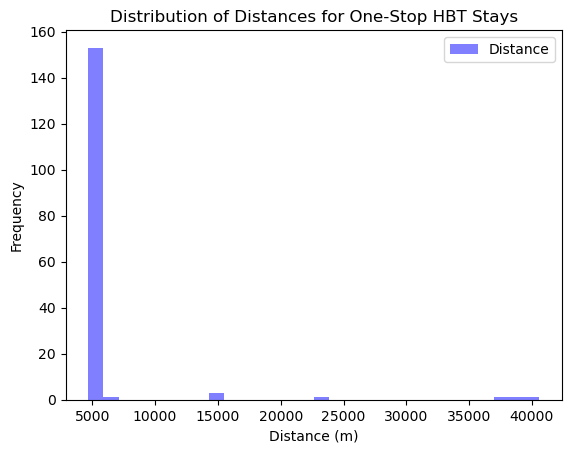

In [132]:
# Distribution of distances for all one_stop_hbt stays
plt.hist(one_stop_hbt['last_dist'], bins=30, color='blue', alpha=0.5, label='Distance')
plt.title("Distribution of Distances for One-Stop HBT Stays")
plt.xlabel("Distance (m)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

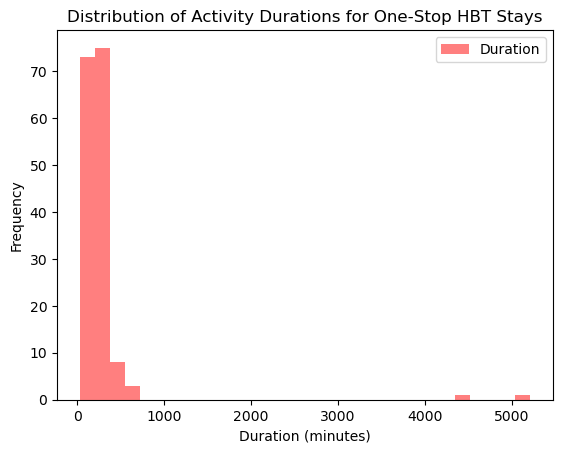

In [133]:
# Distribution of activity durations for all one_stop_hbt stays
plt.hist(one_stop_hbt['last_activity_duration'], bins=30, color='red', alpha=0.5, label='Duration')
plt.title("Distribution of Activity Durations for One-Stop HBT Stays")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Spectral Mixture Experiments

#### Predict Next Location Using Last Location and Leaving Hour Encoding

In [134]:
# Use variables to specify the columns to encode
item1 = 'last_one'
item2 = 'leaving_hour'

# Encode the data such that each combination of origin and destination is a unique number
# Create a list of unique last_two combinations
unique_combinations = df[[item1, item2]].drop_duplicates().reset_index(drop=True)

# Create a dictionary of unique origin-destination combinations
unique_combinations_dict = dict(zip(range(0, len(unique_combinations)), unique_combinations.values.tolist()))

# Encode the origins and destinations
df['combinations'] = df.apply(lambda x: encode_combinations(x, item1, item2, unique_combinations_dict), axis=1)

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set['combinations'].values, dtype=torch.float32)
x_test = torch.tensor(test_set['combinations'].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [135]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [136]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 3.673
Iter 2/100 - Loss: 3.413
Iter 3/100 - Loss: 3.249
Iter 4/100 - Loss: 3.099
Iter 5/100 - Loss: 2.980
Iter 6/100 - Loss: 2.880
Iter 7/100 - Loss: 2.790
Iter 8/100 - Loss: 2.705
Iter 9/100 - Loss: 2.629
Iter 10/100 - Loss: 2.568
Iter 11/100 - Loss: 2.522
Iter 12/100 - Loss: 2.483
Iter 13/100 - Loss: 2.450
Iter 14/100 - Loss: 2.419
Iter 15/100 - Loss: 2.393
Iter 16/100 - Loss: 2.369
Iter 17/100 - Loss: 2.349
Iter 18/100 - Loss: 2.331
Iter 19/100 - Loss: 2.315
Iter 20/100 - Loss: 2.301
Iter 21/100 - Loss: 2.289
Iter 22/100 - Loss: 2.277
Iter 23/100 - Loss: 2.267
Iter 24/100 - Loss: 2.258
Iter 25/100 - Loss: 2.250
Iter 26/100 - Loss: 2.242
Iter 27/100 - Loss: 2.235
Iter 28/100 - Loss: 2.229
Iter 29/100 - Loss: 2.224
Iter 30/100 - Loss: 2.219
Iter 31/100 - Loss: 2.214
Iter 32/100 - Loss: 2.210
Iter 33/100 - Loss: 2.207
Iter 34/100 - Loss: 2.204
Iter 35/100 - Loss: 2.201
Iter 36/100 - Loss: 2.198
Iter 37/100 - Loss: 2.196
Iter 38/100 - Loss: 2.194
Iter 39/100 - Loss: 2

In [137]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_prediction = likelihood(model(x_test))

In [138]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -2,  0,  0, -2,  0,  0,  0,  0,  0,  0,  1,  0,  0,  7,
         0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -3,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0, -2,  0,  0,  0,  0, -3,  0,
         0,  0,  0,  0,  0, -2,  0, -2, -1,  0,  0, -3, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [139]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 83.87%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_40517/3212484906.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


#### Predict Next Location Using Last Location and Leaving Hour (w/o Encoding)

In [246]:
features = ['last_one', 'leaving_hour']

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set[features].values, dtype=torch.float32)
x_test = torch.tensor(test_set[features].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [269]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Through manual testing, we found 4 mixtures to be the best tradeoff of accuracy and runtime
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=2)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [270]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200 # Empirically we found around 200 iterations allows consistent convergence

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: 3.139
Iter 11/200 - Loss: 2.365
Iter 21/200 - Loss: 2.217
Iter 31/200 - Loss: 2.162
Iter 41/200 - Loss: 2.149
Iter 51/200 - Loss: 2.143
Iter 61/200 - Loss: 2.138
Iter 71/200 - Loss: 2.131
Iter 81/200 - Loss: 2.128
Iter 91/200 - Loss: 2.126
Iter 101/200 - Loss: 2.123
Iter 111/200 - Loss: 2.120
Iter 121/200 - Loss: 2.118
Iter 131/200 - Loss: 2.116
Iter 141/200 - Loss: 2.115
Iter 151/200 - Loss: 2.112
Iter 161/200 - Loss: 2.120
Iter 171/200 - Loss: 2.113
Iter 181/200 - Loss: 2.111
Iter 191/200 - Loss: 2.110


In [271]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_prediction = likelihood(model(x_test))

In [272]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -3,  0,  0, -2,  0,  0,  0,  0,  0,  0,  1,  0,  0, 10,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -2,  0,  0,  0,  0, -3,  0,
         0,  0,  0,  0,  0, -2,  0, -4, -2,  0,  0, -8,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
         0,  0,  0], dtype=torch.int32)

In [273]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 87.10%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/3212484906.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


#### Predict Next Location Using Last Location, Leaving Hour, and Day of Week

In [274]:
features = ['last_one', 'leaving_hour', 'day_of_week']

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set[features].values, dtype=torch.float32)
x_test = torch.tensor(test_set[features].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [280]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Through manual testing, we found 8 mixtures to be the best tradeoff of accuracy and runtime
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=8, ard_num_dims=3)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [281]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100 # Empirically we found around 100 iterations allows consistent convergence

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 2.207
Iter 11/100 - Loss: 2.073
Iter 21/100 - Loss: 2.051
Iter 31/100 - Loss: 2.033
Iter 41/100 - Loss: 2.019
Iter 51/100 - Loss: 2.009
Iter 61/100 - Loss: 2.005
Iter 71/100 - Loss: 2.002
Iter 81/100 - Loss: 2.004
Iter 91/100 - Loss: 1.999


In [282]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_prediction = likelihood(model(x_test))

In [283]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([  0,   0,   0,   0,  -2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   9,   0,  -4,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,  -4,  -1,   0,   4,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0, -11,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int32)

In [284]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 88.17%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/3212484906.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


#### Predict Next Location Based on Multiple Features

In [383]:
features = ['last_one', 'leaving_hour', 'is_weekday', 'second_last_one']

# Get training and testing data
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

# Get x data
x_train = torch.tensor(train_set[features].values, dtype=torch.float32)
x_test = torch.tensor(test_set[features].values, dtype=torch.float32)

# Convert cluster column to tensor
y_train = torch.tensor(train_set['cluster'].values, dtype=torch.float32)
y_actual = torch.tensor(test_set['cluster'].values, dtype=torch.float32)

In [389]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Through manual testing, we found 10 mixtures to be the best tradeoff of accuracy and runtime
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=10, ard_num_dims=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(x_train, y_train, likelihood)

In [390]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100 # Empirically we found around 100 iterations allows consistent convergence

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 2.423
Iter 11/100 - Loss: 2.090
Iter 21/100 - Loss: 2.023
Iter 31/100 - Loss: 2.006
Iter 41/100 - Loss: 1.996
Iter 51/100 - Loss: 1.992
Iter 61/100 - Loss: 1.989
Iter 71/100 - Loss: 1.985
Iter 81/100 - Loss: 1.980
Iter 91/100 - Loss: 1.977


In [391]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_prediction = likelihood(model(x_test))

In [392]:
torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)

/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/1286424123.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int)


tensor([ 0,  0,  0,  0, -2,  0,  0,  5,  0,  0,  0,  0,  0,  0,  1,  0,  0,  9,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -4,  0,
         0,  0,  0,  0,  0,  0,  0, -2, -4,  0,  1,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], dtype=torch.int32)

In [393]:
print("We predict the next location (current cluster) with an accuracy of: ", 
      '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")

We predict the next location (current cluster) with an accuracy of: 89.25%


/var/folders/9q/4yjzjfts7dl9f0m7h5315w200000gp/T/ipykernel_43346/3212484906.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  '%.2f'%((len(y_actual) - torch.count_nonzero(torch.tensor(y_actual - observed_prediction.mean, dtype=torch.int))) / len(y_actual) * 100), "%", sep="")


## Conventional ML Baselines

## Notes

- I would like to note that regarding conventional ML baselines for classification, random forest does very well with an average of about 91% accuracy predicting the next cluster given just the previous one and the leaving hour.

- From my experiments, it seems that having two points of reference tend to do really well... three points has yet to be seen for an overall significant improvement. For instance, Using the last three locations visited vs the last two locations visited to predict the day of the week show not much difference in accuracy. And from above, seeing as how Random Forest only requires 2 features to predict at 91% accuracy seems to be pretty good. Further research and experimentation will be required...

- The reason why I encode using just last_one and not last_two or last_three is because these tuples are not considered sequences, rather, are taken into account as a single unit. However, we have empirical evidence that there is better predicitive power when considering the similarity of trip locations as a sequence. For instance, finding similarity between [0, 1, 2] and [0, 1, 3] shows us that we have similarity 2 out of three as opposed to having 0 similarity in terms of same vs not-same thinking. Therefore, I use last_one as a baseline for encoding, but I want to find new methods that allow me to breakdown and compare these sequences (ex: Hamming Distance).